In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

import pandas as pd
import pickle as pkl

import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F



In [6]:
path_to_data = r'/Users/sooophias/Downloads/UW/599/finalproject/CSE599_data.pkl'
data = pd.read_pickle(path_to_data)
data = data.dropna()
data['date']

0       2021-11-15
1       2021-11-15
2       2021-11-15
3       2021-11-15
4       2021-11-15
           ...    
1033    2021-11-17
1034    2021-11-17
1035    2021-11-17
1036    2021-11-17
1037    2021-11-17
Name: date, Length: 884, dtype: object

In [7]:
no_stim_data = data[data['stim'] == 0]
oneday_data = no_stim_data[no_stim_data['date'] == '2021-11-15']


names = data.columns

# stim_inputs =stim_oneday_data[names[3:]]
# stim_inputs = torch.tensor(stim_inputs.values).to(torch.float32)

pd_inputs = oneday_data[names[3:]]
inputs = torch.tensor(pd_inputs.values)
inputs = inputs.to(torch.float32)


angle_outputs = oneday_data['angle'].values
outputs = torch.zeros(angle_outputs.shape[0], 4, dtype = torch.long)



for i in range(angle_outputs.shape[0]):
    ind = angle_outputs[i]/90 -1
    outputs[i, int(ind)] = 1


ind_list = torch.argmax(outputs, dim = 1)
print(torch.sum(ind_list == 0))
print(torch.sum(ind_list == 1))
print(torch.sum(ind_list == 2))
print(torch.sum(ind_list == 3))


tensor(66)
tensor(58)
tensor(56)
tensor(59)


In [8]:
class RNN(nn.Module):
    def __init__(self, input_size,  hidden_size, output_size, nonlinearity = 'tanh'):

        super(RNN, self).__init__()
        #self.hidden_size = hidden_size[0]
        # self.layer1 = nn.Linear(input_size, hidden_size[0])
        #self.layer2 = nn.Linear(hidden_size[0], hidden_size[1])
        #self.layer3 = nn.Linear(hidden_size[1], output_size)
        self.rnn = nn.RNN(input_size, hidden_size, num_layers = 1, nonlinearity = 'tanh')
        self.out_layer = nn.Linear(hidden_size, output_size)
        self.logsoftmax = nn.Softmax(dim = 1)


    def forward(self, x):
        # rnn_out = torch.squeeze(rnn_out)
        # print(rnn_out.shape)

       # hidden1 = F.tanh(self.layer1(x))
        #hidden2 = F.tanh(self.layer2(hidden1))
        # hidden2 = F.tanh(self.layer2(hidden1))
        # output  = F.relu(self.layer3(hidden2))
        # = self.layer4(hidden3)

        #output = F.softmax(self.layer3(hidden2), dim = 1)
       
        hidden1, _ = self.rnn(x)
        output = self.out_layer(hidden1)
        output = self.logsoftmax(output)
       
        return  output, hidden1
    
    

    def initHidden(self):
        return torch.rand(1, self.hidden_size)
    
    

In [9]:
class MyDataset(Dataset):
    def __init__(self, inputs, outputs):
        super().__init__()
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]

In [10]:
def train_model(model, loader, optimizer, loss_fn, epochs, threshold): 

    loss_list = []

    for epoch in range(epochs):
        total_loss = 0
        prev_loss = 0
        for batch_idx, batch in enumerate(loader):
        
            inputs, target = batch
            optimizer.zero_grad()
            # print(input.shape)
        
            output, _ = model(inputs)
            # print(output.shape)
            loss = 0
            for l in range(output.shape[0]):
                loss+= loss_fn(output[l, :].double(), target[l, :].double())
            

            # loss = loss_fn(output, target)
            total_loss += loss.item()
            loss.backward()
            # grad = np.mean([p.grad.norm() for p in model.parameters()])
           

            # torch.nn.utils.clip_grad_norm_(model.parameters(), threshold)
            optimizer.step()

            if abs(prev_loss - loss) <= 1e-6:
                break
            else:
                prev_loss = loss

        
        #if epoch % 500 == 0: 
            # print(epoch % 1000)
         #   print("Epoch:" + str(epoch))
          #  print("loss: " + str(loss.item()))
            

        loss_list.append(total_loss / len(loader))


    return loss_list, model

In [17]:
def test_model(model, inputs, targets):

    outputs, _ = model(inputs)
    # print(outputs)
    pred = torch.argmax(outputs, dim = 1)
  
    targets_pos = torch.argmax(targets, dim = 1)

    pred_acc = torch.sum(pred == targets_pos) / inputs.shape[0]
    


    return pred_acc, targets_pos, pred



In [18]:
def train_main(inputs, outputs):
    input_size = 168
    output_size = 4
    hidden_size = 30
    learning_rate = 1e-4
    decay = 0.1
    batch_size = 10
    epochs = 3000
    threshold = 2

    net =  RNN(input_size, hidden_size, output_size)
    optimizer = optim.Adam(net.parameters(), lr = learning_rate, weight_decay = decay)
    loss_fn = nn.CrossEntropyLoss()
    # 
    dataset = MyDataset(inputs, outputs)
    loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)
        
    avg_loss, net = train_model(net, loader, optimizer, loss_fn, epochs, threshold)
    plt.figure(figsize=(10, 4))

    plt.title("Learning Rate = " + str(learning_rate))

    plt.plot(avg_loss)
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.show()

# plt.savefig("loss_n_grad_lr_" + str(learning_rate)+".png")
   
    return net

In [19]:
def prediction_details(pred, target, pred_acc):
    matrix = np.zeros((4, 4))
    for i in range(pred.shape[0]):
        matrix[pred[i], target[i]] += 1
    matrix = matrix / np.sum(matrix, 1)
    
    plt.figure
    plt.title("Prediciton accuracy = " + str(round(pred_acc.item(), 3)))
    plt.imshow(matrix,  vmin = 0, vmax = 1)
    
    plt.colorbar()
    
    plt.show()
    return matrix


In [20]:
#  separate the data into training and testing data 
def validataion_network(inputs, labels, fold):
    assert(inputs.shape[0] == labels.shape[0])
    n_trail = inputs.shape[0]
    ind_list = np.array_split(np.random.permutation(n_trail), fold)
    train_acc_list = []
    test_acc_list = []
    test_M= []


    for i in range(fold): # doing five fold validataion
        print("Fold " + str(i))
        print("Training Start....")
        test_ind = ind_list[i]
        train_ind =  np.squeeze(np.where(-1*np.isin(range(n_trail), test_ind) == 0))
   
        train_data = inputs[train_ind, :]
        train_label = labels[train_ind, :]


        test_data = inputs[test_ind, :]
        test_label = labels[test_ind, :]

        net = train_main(train_data, train_label)
        print("Training finished, start testing...")
        print("training acc")
        train_acc, train_target, train_pred = test_model(net, train_data, train_label)
        train_acc_list.append(train_acc)
        _= prediction_details(train_pred, train_target, train_acc)


        print("testing acc")
        test_acc, test_target, test_pred = test_model(net, test_data, test_label)
        test_acc_list.append(test_acc_list)
        test_matrix = prediction_details(test_pred, test_target, test_acc)


        if test_M == []:
            test_M = test_matrix
        else:
            test_M += test_matrix
        
    test_M = test_M /5
    print(test_M)
    return train_acc_list, test_acc_list, test_M

    

Fold 0
Training Start....


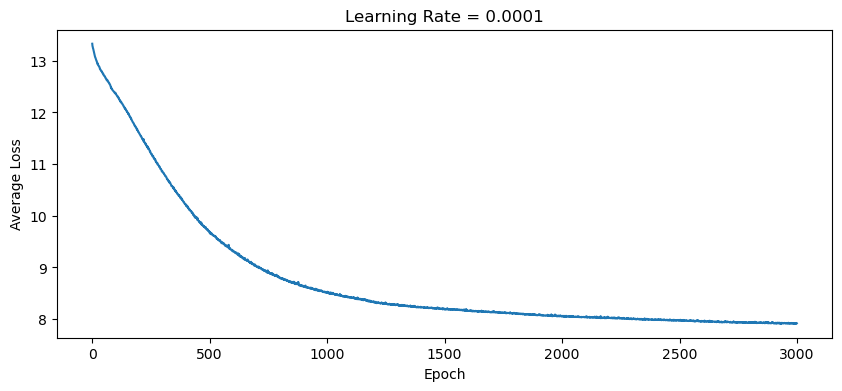

Training finished, start testing...
training acc


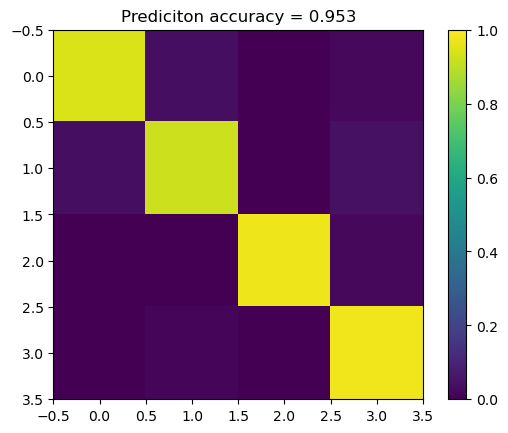

testing acc


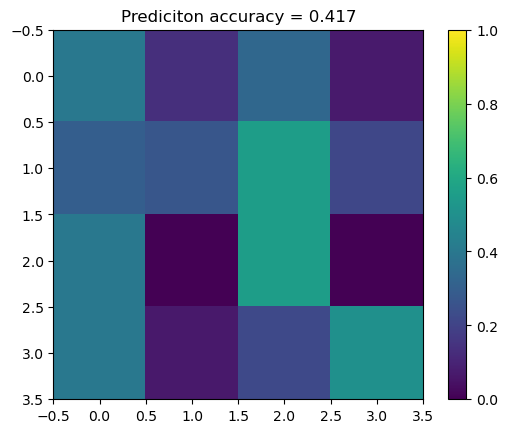

Fold 1
Training Start....


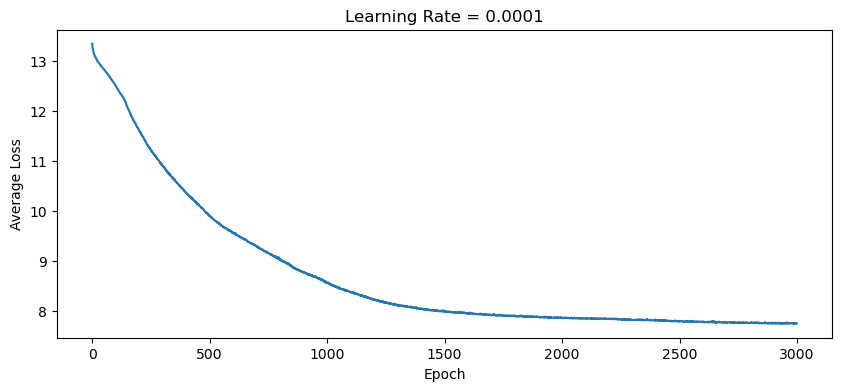

Training finished, start testing...
training acc


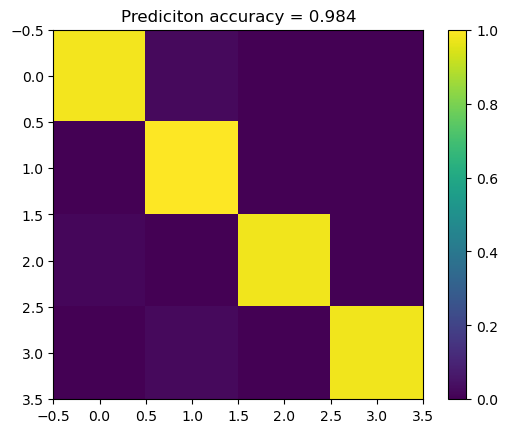

testing acc


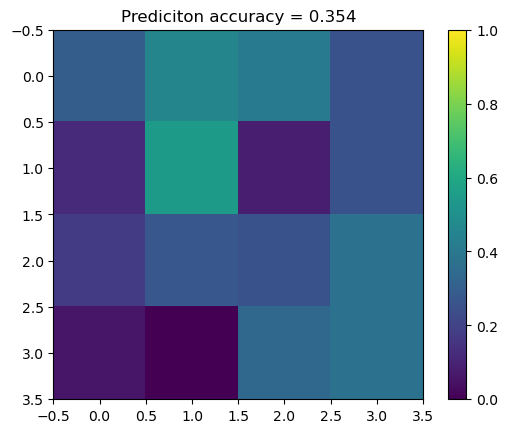

Fold 2
Training Start....


/var/folders/l7/hl0zxkd55pscq97_d4gxrx_00000gn/T/ipykernel_91562/176735117.py:38: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if test_M == []:


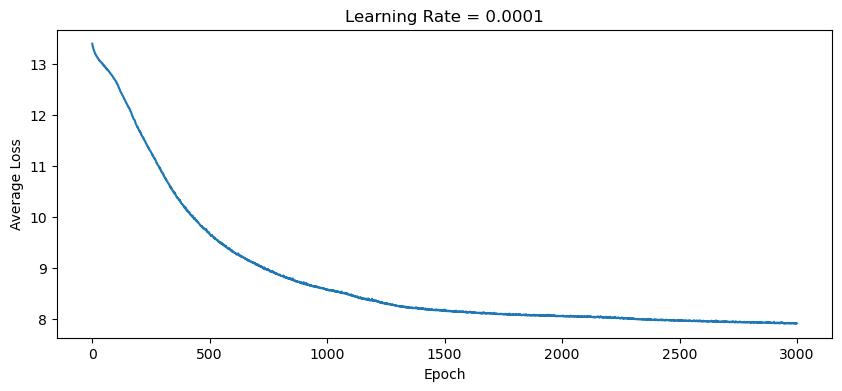

Training finished, start testing...
training acc


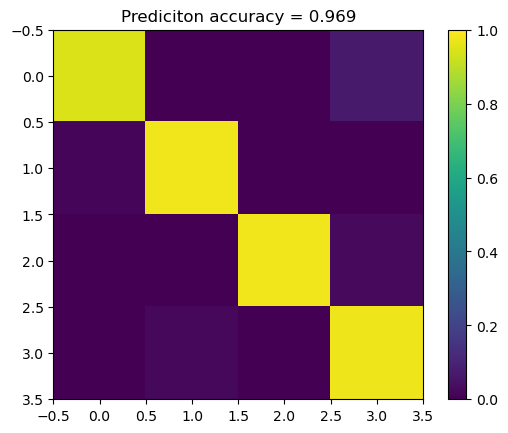

testing acc


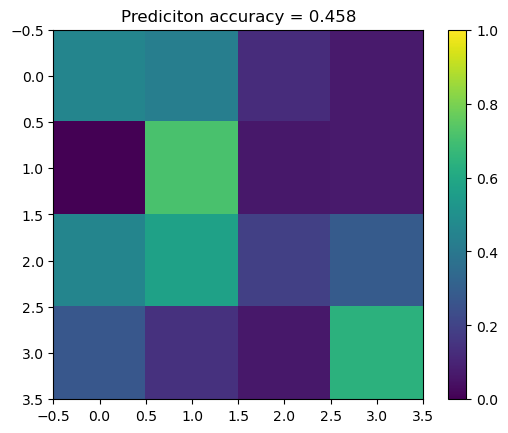

Fold 3
Training Start....


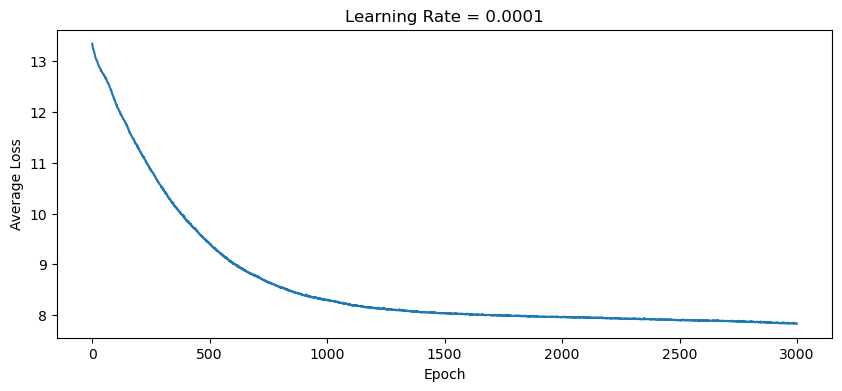

Training finished, start testing...
training acc


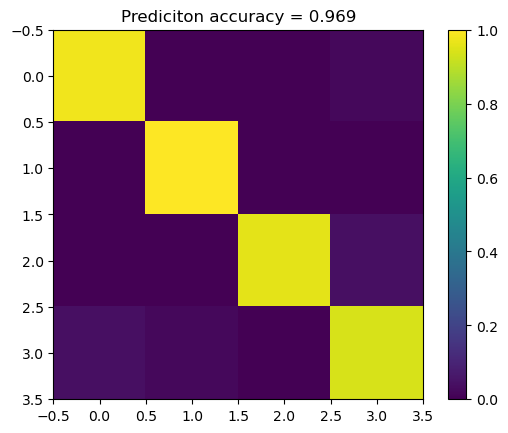

testing acc


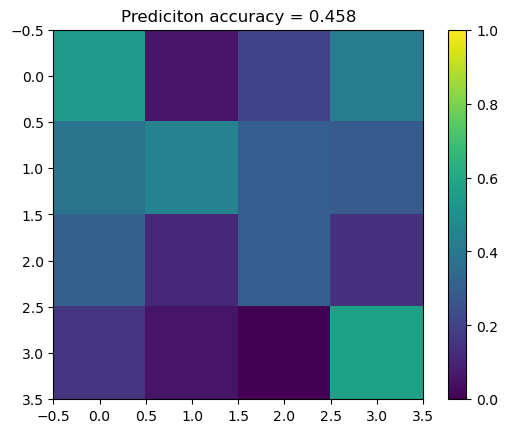

Fold 4
Training Start....


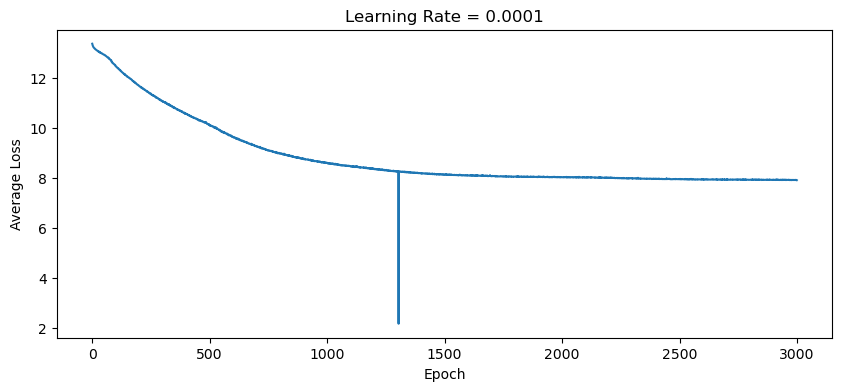

Training finished, start testing...
training acc


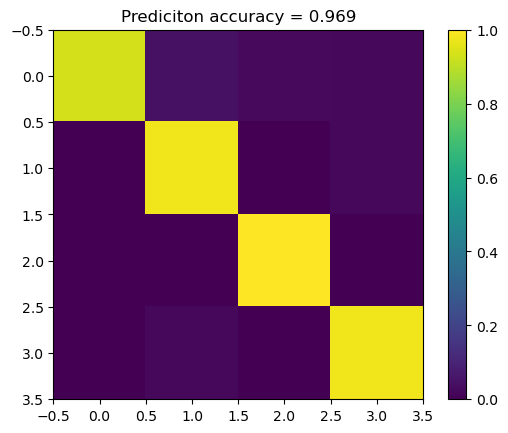

testing acc


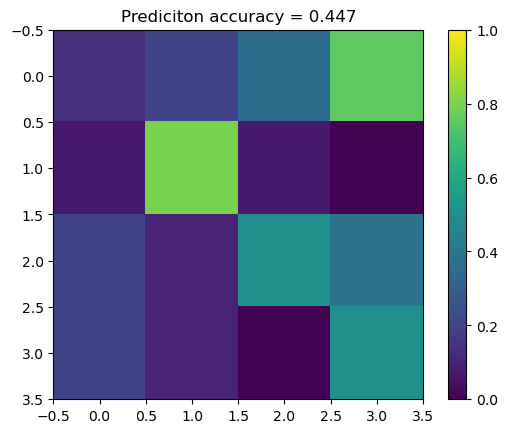

[[0.36409159 0.25440115 0.28642857 0.31428571]
 [0.17378582 0.55417027 0.21456349 0.16428571]
 [0.30774167 0.21105339 0.35861111 0.23571429]
 [0.21707939 0.07301587 0.12361111 0.51785714]]


In [21]:
train_acc_list, test_acc_list, test_M = validataion_network(inputs, outputs, 5)

In [109]:
pred_output_state, hidden_states = net(inputs)

NameError: name 'net' is not defined

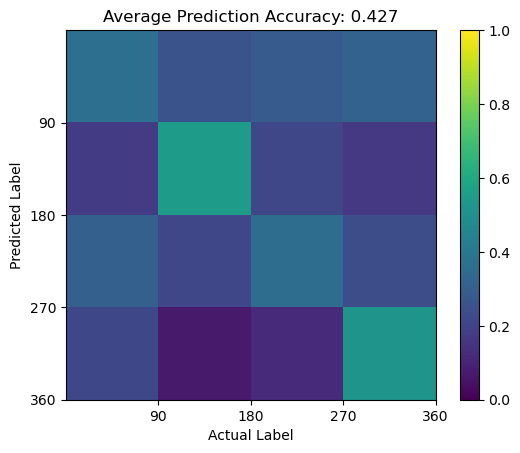

In [22]:
plt.figure
plt.imshow(test_M)
plt.title("Average Prediction Accuracy: 0.427")
plt.xlabel("Actual Label")
plt.ylabel("Predicted Label")
plt.xticks(ticks = [0.5, 1.5, 2.5, 3.5], labels = [90, 180, 270, 360])
plt.yticks(ticks = [0.5, 1.5, 2.5, 3.5], labels = [90, 180, 270, 360])
plt.colorbar()
plt.clim([0, 1])
plt.savefig("test_prediction_accuracy.png")
plt.show()


In [ ]:
# use LDA to find two hidden units that best separate the four classes
output_ind = torch.argmax(outputs, dim = 1).detach().numpy()
unit1 = 0
unit2 = 0
max_acc = 0
n_hidden_units = hidden_states.shape[1]
for k in range(n_hidden_units-1):
    for j in range(k+1, n_hidden_units):
        clf = LDA()
        units = hidden_states[:, [k, j]].detach().numpy()
        clf.fit(units,  output_ind)
        lda_pred = clf.predict(units)
        lda_acc = np.sum(lda_pred == output_ind)/output_ind.shape[0]
        if lda_acc > max_acc:
            unit1 = k
            unit2 = j
            max_acc = lda_acc


: 

: 

<function matplotlib.pyplot.show(close=None, block=None)>

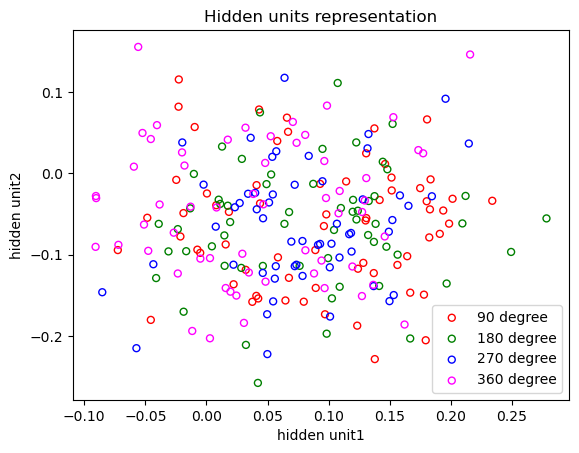

In [831]:
hidden_states.shape
plt.figure
hiddens = hidden_states.detach().numpy()

output_ind = torch.argmax(outputs, dim = 1).detach().numpy()
color_list = ['red', 'green', 'blue', 'magenta']
for label in range(4):
    ind = output_ind == label
    plt.scatter(hiddens[ind, unit1], hiddens[ind, unit2], s = 25, facecolors='none', edgecolors=color_list[label])
    plt.legend(["90 degree", "180 degree", "270 degree", "360 degree"])
    plt.xlabel("hidden unit1")
    plt.ylabel("hidden unit2")
    plt.title("Hidden units representation")
plt.show
#plt.savefig("hidden_unit_rep.png")


In [29]:
train_cc = np.array([0.953,0.984,0.969,0.969,0.969])
test_cc = np.array([0.417,0.354,0.458,0.458,0.447])

avg_train_acc = np.mean(train_cc)
train_std = np.std(train_cc)

print(avg_train_acc)
print(train_std)


avg_test_acc = np.mean(test_cc)
test_std = np.std(test_cc)

print(avg_test_acc)
print(test_std)

0.9687999999999999
0.00980612053770502
0.42679999999999996
0.03937207131965502


: 

: 

: 